In [ ]:
!pip install -q replay-rec rs_datasets

In [ ]:
from datetime import datetime

import matplotlib.pyplot  as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rs_datasets import MovieLens
from replay.metrics import HitRate, NDCG, Coverage, OfflineMetrics
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.splitters.time_splitter import TimeSplitter
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Загрузка датасета

In [ ]:
ml = MovieLens('1m')
data = ml.ratings

Оставляем пользователей с не менее чем 20 взаимодействиями.

In [ ]:
data = MinCountFilter(num_entries=20).transform(data)

### Разбиение данных

In [ ]:
train, test = TimeSplitter(time_threshold=0.2,
                           drop_cold_users=True,
                           drop_cold_items=True,
                           query_column='user_id').split(data)

In [ ]:
print('Юзеров в train = {}'.format(train.user_id.nunique()))
print('Айтемов в train = {}'.format(train.item_id.nunique()))

Юзеров в train = 5400
Айтемов в train = 3662


Тестовая выборка будет содержать фильмы с оценкой не менее 4

In [ ]:
test = LowRatingFilter(value=4).transform(test)
test = test[test['user_id'].isin(train['user_id'].unique())]

Применим энкодинг. Чтобы id юзера и айтема были их индексами в разряженной матрице.


In [ ]:
# Применяем энкодинг, чтобы id айтема и юзера был его индексом для удобства
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=10000)
train[['user_id','item_id']] = enc.fit_transform(train[['user_id','item_id']]).astype(int)
test[['user_id','item_id']] = enc.transform(test[['user_id','item_id']]).astype(int)

### SLIM

In [ ]:
class Slim:
    def __init__(self, alpha=0.1, l1_ratio=0.5, tol=0.01):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.tol = tol

    def fit(self, train):
        self.train = train
        self.X = pd.pivot_table(train, values='rating', index='user_id', columns='item_id').fillna(0).to_numpy()
        num_items = self.X.shape[1]
        self.W = np.zeros((self.X.shape[1], self.X.shape[1]))
        model = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio, tol=self.tol)
        for j in tqdm(range(num_items), desc='progress'):
            y = self.X[:, j].copy()
            self.X[:, j] = 0
            model.fit(self.X, y)

            model_coef = model.coef_
            model_coef[model_coef < 0] = 0
            self.W[:, j] = model_coef

            self.X[:, j] = y

    def predict(self, user_id, topk=10, filter_seen=True):
        rank_matrix = self.X @ self.W

        if filter_seen:
            rank_matrix = np.multiply(rank_matrix, np.invert(self.X.astype(bool)))

        labels_topk = np.argsort(rank_matrix, axis=1)[:, -topk:][:,::-1]
        test_history = self.train[self.train.user_id.isin(user_id)].sort_values('user_id')
        last_item = test_history.groupby('user_id')['item_id'].apply(lambda x: x.iloc[-1]).reset_index(drop=True)
        pred = pd.DataFrame({'user_id': np.repeat(np.sort(user_id), 10), 'item_id': list(labels_topk[last_item].reshape(-1,1))})
        pred = pred.explode('item_id')
        pred['rating'] = [x % topk for x in range(len(pred))]

        return pred

# Первая версия

In [ ]:
model = Slim(alpha=0.1, l1_ratio=1)
model.fit(train)

progress: 100%|██████████| 3662/3662 [16:59<00:00,  3.59it/s]


In [ ]:
predict = model.predict(test.user_id.unique())

In [ ]:
metrics = [HitRate(topk=10), NDCG(topk=10), Coverage(topk=10)]
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.15508021390374332,
 'NDCG@10': 0.014458466966258243,
 'Coverage@10': 0.002730748225013654}

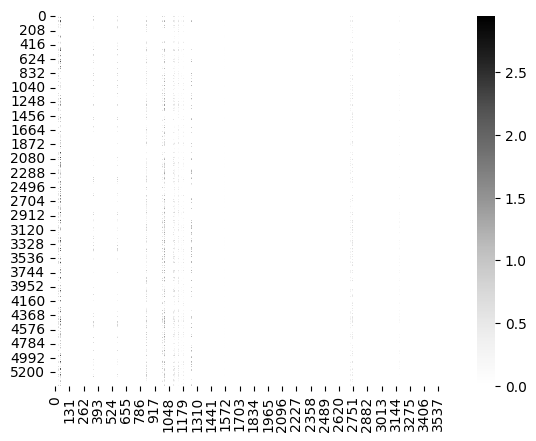

In [ ]:
sns.heatmap(model.X @ model.W, cmap='Greys');

# Tuned parameters

In [ ]:
%%time
model = Slim(alpha=0.05, l1_ratio=0.75)
model.fit(train)

progress: 100%|██████████| 3662/3662 [31:59<00:00,  1.91it/s]

CPU times: user 29min 36s, sys: 14min 19s, total: 43min 55s
Wall time: 32min 1s


In [ ]:
%%time
predict = model.predict(test.user_id.unique(), filter_seen=True)

CPU times: user 9.49 s, sys: 887 ms, total: 10.4 s
Wall time: 7.52 s


In [ ]:
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.4001782531194296,
 'NDCG@10': 0.07831631084832354,
 'Coverage@10': 0.2097214636810486}

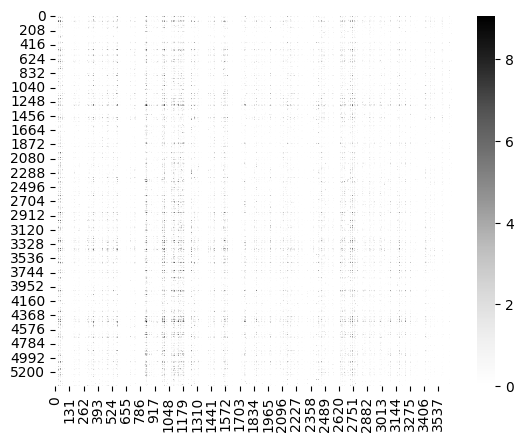

In [ ]:
sns.heatmap(model.X @ model.W, cmap='Greys');